Data Preperation

In [2]:
import os
import shutil
import re

base_dir = "cash/"

# Create training folder
files = os.listdir(base_dir)

def train_maker(name):
  train_dir = f"{base_dir}/train/{name}"
  for f in files:
        search_object = re.search(name, f)
        if search_object:
          shutil.move(f'{base_dir}/{name}', train_dir)

train_maker("RM1")
train_maker("RM20")
train_maker("RM50")

# Make the validation directories
try:
    os.makedirs("Cash/val/RM1")
    os.makedirs("Cash/val/RM20")
    os.makedirs("Cash/val/RM50")
except OSError:
    print ("Creation of the directory %s failed")
else:
    print ("Successfully created the directory %s ")

Successfully created the directory %s 


In [3]:
#  Create validation folder

rm1_train = base_dir + "train/RM1/"
rm1_val = base_dir + "val/RM1/"

rm20_train = base_dir + "train/RM20/"
rm20_val = base_dir + "val/RM20/"

rm50_train = base_dir + "train/RM50/"
rm50_val = base_dir + "val/RM50/"

rm1_files = os.listdir(rm1_train)
rm20_files = os.listdir(rm20_train)
rm50_files = os.listdir(rm50_train)

['rm1_back_122.jpg', 'rm1_back_136.jpg', 'rm1_front_299.jpg', 'rm1_front_272.jpg', 'rm1_front_266.jpg', 'rm1_back_297.jpg', 'rm1_front_306.jpg', 'rm1_back_254.jpg', 'rm1_front_312.jpg', 'rm1_back_268.jpg', 'rm1_front_96.jpg', 'rm1_front_82.jpg', 'rm1_back_31.jpg', 'rm1_front_138.jpg', 'rm1_front_139.jpg', 'rm1_front_111.jpg', 'rm1_back_30.jpg', 'rm1_front_97.jpg', 'rm1_back_269.jpg', 'rm1_front_313.jpg', 'rm1_front_307.jpg', 'rm1_back_255.jpg', 'rm1_back_296.jpg', 'rm1_front_267.jpg', 'rm1_front_273.jpg', 'rm1_front_298.jpg', 'rm1_back_137.jpg', 'rm1_back_123.jpg', 'rm1_back_135.jpg', 'rm1_back_121.jpg', 'rm1_back_109.jpg', 'rm1_front_265.jpg', 'rm1_front_271.jpg', 'rm1_front_259.jpg', 'rm1_front_311.jpg', 'rm1_back_257.jpg', 'rm1_front_305.jpg', 'rm1_front_339.jpg', 'rm1_back_32.jpg', 'rm1_front_113.jpg', 'rm1_front_112.jpg', 'rm1_back_33.jpg', 'rm1_front_94.jpg', 'rm1_back_256.jpg', 'rm1_front_304.jpg', 'rm1_front_310.jpg', 'rm1_back_295.jpg', 'rm1_front_258.jpg', 'rm1_front_270.jpg'

Load the data

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [5]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [6]:
# Set the directory for the data
data_dir = 'cash/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
  chosen_transforms[x])
                  for x in ['train', 'val']}

In [26]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=0)
              for x in ['train', 'val']}

In [27]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

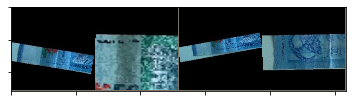

In [29]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Setting up the pre-trained model

In [30]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 3)

In [31]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [32]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

Visualize

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                print(class_names[preds[j]])
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/2
----------
Iterating through data...
train Loss: 0.5312 Acc: 0.7903
Iterating through data...
val Loss: 0.0687 Acc: 1.0000

Epoch 1/2
----------
Iterating through data...
train Loss: 0.2148 Acc: 0.9147
Iterating through data...
val Loss: 0.0479 Acc: 1.0000

Epoch 2/2
----------
Iterating through data...
train Loss: 0.2872 Acc: 0.9078
Iterating through data...
val Loss: 0.0546 Acc: 0.9825

Training complete in 18m 49s
Best val Acc: 1.000000


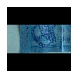

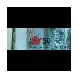

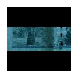

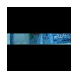

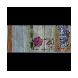

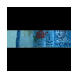

In [35]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)


RM1


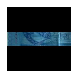

RM50


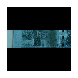

RM20


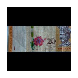

RM50


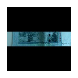

RM20


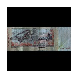

RM1


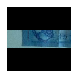

In [39]:
visualize_model(base_model)
plt.show()